In [1]:
%run "../head.py"

In [20]:
from cooler import Cooler
from hic_basic.compartment import compartments
from hic_basic.coolstuff import cool2mat
from hic_basic.hicio import load_json
from hic_basic.plot.hic import plot_compartment
from plotly.subplots import make_subplots
from scipy.ndimage import rotate

def plot_compartment_trapezoid(coolp, vec_file, region, balance=True, strata=20, title="TITLE", quant=0.01, minmax="min", cmap="RdBu_r", eigen_col="E1", fillna=False, strip=False, mask_eig_na=True, **kwargs):
    square_fig, cmat, extent, eig_dat1 = plot_compartment(
        coolp,
        vec_file,
        region=region,
        eigen_col=eigen_col,
        balance=balance,
        title = title,
        strip = strip,
        mask_eig_na = mask_eig_na,
        fillna=fillna,
        give_mat=True,
        quant=quant,
        minmax=minmax,
        eq_hist=False,
        cmap = cmap,
        ignore_diags=False
    )
    min_v = cmat.min().min()
    cmat = cmat.fillna(min_v - 100)
    r_cmat = rotate(cmat, 45, cval=np.nan, order=1)
    r_cmat[r_cmat < min_v-0.5] = np.nan
    df = pd.DataFrame(
        r_cmat
    )
    N = df.shape[0]
    if N % 2 == 0:
        trapezoid = df.iloc[N//2 : N//2 +strata, :]
    else:
        trapezoid = df.iloc[N//2 + 1 : N//2 +strata, :]
    default_kwargs = {}
    if isinstance(extent, tuple):
        default_kwargs["zmin"] = extent[0]
        default_kwargs["zmax"] = extent[1]
    else:
        default_kwargs["zmin"] = -extent
        default_kwargs["zmax"] = extent
    kwargs = {**default_kwargs, **kwargs}
    fig = go.Figure(
        data = go.Heatmap(
            z = trapezoid,
            colorscale = cmap,
            **kwargs
        )
    )
    fig.update_layout(
        plot_bgcolor = "white",
        height = trapezoid.shape[0]*5,
        width = trapezoid.shape[1]*5,
        xaxis = dict(
            domain = [0.1, 0.9]
        ),
        yaxis = dict(
            domain = [0.1, 0.9]
        )
    )
    return fig
def plot_compartment_trapezoid_2tracks(coolp0, vec_file1, vec_file2, region, balance=True, strata=20, title="TITLE", quant=0.01, minmax="min", cmap="RdBu_r", eigen_col="E1", fillna=False, strip=False, mask_eig_na=True,
    vec_file0=None, coolp1=None, coolp2=None):
    if vec_file0 is None:
        vec_file0 = vec_file1
    eig_dats = []
    for i, (vec_file, coolp) in enumerate(zip([vec_file0, vec_file1, vec_file2], [coolp0, coolp1, coolp2])):
        if coolp is None:
            coolp = coolp0
        _square_fig, _cmat, _extent, eig_dat = plot_compartment(
            coolp,
            vec_file,
            region=region,
            eigen_col=eigen_col,
            balance=balance,
            title = title,
            strip = strip,
            mask_eig_na = mask_eig_na,
            fillna=fillna,
            give_mat=True,
            quant=quant,
            minmax=minmax,
            eq_hist=False,
            cmap = cmap,
            ignore_diags=False
        )
        if i == 0:
            square_fig = _square_fig
            cmat = _cmat.copy()
            extent = _extent
        else:
            eig_dats.append(eig_dat)
        #print(eig_dat)
    fig = make_subplots(
        rows = 3,
        cols = 1,
        shared_xaxes = False,
        shared_yaxes = False,
        vertical_spacing = 0.05,
        row_heights = [0.6, 0.2, 0.2]
    )
    # --- add heatmap --- #
    heatmap = plot_compartment_trapezoid(coolp0, vec_file0, region, balance, strata, title, quant, minmax, cmap, eigen_col, fillna, strip, mask_eig_na)
    fig.add_trace(
        heatmap.data[0],
        row = 1,
        col = 1
    )
    # --- add tracks --- #
    #clr = Cooler(str(coolp))
    for i, eig_dat in enumerate(eig_dats):
        eigs_fig = px.bar(
            eig_dat, x="start", y = eigen_col, color="AB",
            # blue, 'rgb(33,102,172)'
            color_discrete_map={"B":'rgb(33,102,172)',"A":'rgb(178,24,43)'},
        )
        bar_width = eig_dat["start"].diff().mode()[0]
        eigs_fig.update_traces(
            showlegend = False,
            width = bar_width
        )
        for trace in eigs_fig.data:
            fig.add_trace(trace, row=i+2, col=1)
    ## barplot
    fig.update_traces(
        selector=dict(type="bar"),
        #width=clr.binsize,
        marker=dict(
            line = dict(
                color = "purple", # looks better than black
                width = 0 # this actually tries to removes the line, 
            )
        )
    )
    for row in range(1, 4):
        if row in [2,3]:
            fig.update_yaxes(
                range = [-0.5, 0.5],
                row = row,
                col = 1
            )
        if row != 3:
            fig.update_xaxes(
                visible = False,
                row = row,
                col = 1
            )
        else:
            fig.update_xaxes(
                title = "Genomic Position",
                row = row,
                col = 1
            )
        if row == 1:
            fig.update_yaxes(
                visible = False,
                row = row,
                col = 1
            )
        else:
            fig.update_yaxes(
                title = "E1",
                showline = True,
                linewidth = 1,
                linecolor = "black",
                #nticks = 3,
                row = row,
                col = 1
            )
        
    fig.update_layout(
        plot_bgcolor = "white",
        height = 500,
        width = 700
    )
    return fig
import io
from PIL import Image
def plotly_fig2array(fig):
    #convert a Plotly fig to  a RGB-array
    #fig_bytes = fig.to_image(format="png", height = 1600, width = 1600, scale=4)
    fig_bytes = fig.to_image(format="png", height = 2000, width = 2000, scale=4)
    buf = io.BytesIO(fig_bytes)
    img = Image.open(buf)
    return np.asarray(img)
def plot_compartment_trapezoid_rotate_png(coolp, vec_file, region, balance=True, strata=20, title="TITLE", quant=0.01, minmax="min", cmap="RdBu_r", eigen_col="E1", fillna=False, strip=False, mask_eig_na=True, **kwargs):
    square_fig, cmat, extent, eig_dat1 = plot_compartment(
        coolp,
        vec_file,
        region=region,
        eigen_col=eigen_col,
        balance=balance,
        title = title,
        strip = strip,
        mask_eig_na = mask_eig_na,
        fillna=fillna,
        give_mat=True,
        quant=quant,
        minmax=minmax,
        eq_hist=False,
        cmap = cmap,
        ignore_diags=False
    )
    default_kwargs = dict(
        showscale = False
    )
    if isinstance(extent, tuple):
        default_kwargs["zmin"] = extent[0]
        default_kwargs["zmax"] = extent[1]
    else:
        default_kwargs["zmin"] = -extent
        default_kwargs["zmax"] = extent
    kwargs = {**default_kwargs, **kwargs}
    fig = go.Figure(
        data = go.Heatmap(
            z = cmat,
            colorscale = cmap,
            **kwargs
        )
    )
    fig.update_layout(
        plot_bgcolor = "white",
        height = cmat.shape[0]*5,
        width = cmat.shape[1]*5,
        margin = dict(
            l = 0,
            r = 0,
            b = 0,
            t = 0,
        ),
        xaxis = dict(
            showgrid=False,
            zeroline=False,
            showticklabels=False
        ),
        yaxis = dict(
            showgrid=False,
            zeroline=False,
            showticklabels=False
        )
    )
    farray = plotly_fig2array(fig)
    print("heatmap array", farray.shape)
    r_farray = rotate(farray, -45, cval=np.nan, order=1)
    N = r_farray.shape[0]
    if N % 2 == 0:
        trapezoid = r_farray[N//2 - strata : N//2, :, : ]
    else:
        trapezoid = r_farray[N//2 - strata : N//2 + 1, :, : ]
    print("trapezoid array", trapezoid.shape)
    fig = px.imshow(
        trapezoid
    )
    fig.update_layout(
        plot_bgcolor = "white",
        height = trapezoid.shape[0]*5,
        width = trapezoid.shape[1]*5,
    )
    print("output fig")
    return fig
def plot_compartment_trapezoid_PNGrotate_2tracks(coolp0, vec_file1, vec_file2, region, balance=True, strata=20, title="TITLE", quant=0.01, minmax="min", cmap="RdBu_r", eigen_col="E1", fillna=False, strip=False, mask_eig_na=True,
    vec_file0=None, coolp1=None, coolp2=None):
    if vec_file0 is None:
        vec_file0 = vec_file1
    eig_dats = []
    for i, (vec_file, coolp) in enumerate(zip([vec_file0, vec_file1, vec_file2], [coolp0, coolp1, coolp2])):
        if coolp is None:
            coolp = coolp0
        _square_fig, _cmat, _extent, eig_dat = plot_compartment(
            coolp,
            vec_file,
            region=region,
            eigen_col=eigen_col,
            balance=balance,
            title = title,
            strip = strip,
            mask_eig_na = mask_eig_na,
            fillna=fillna,
            give_mat=True,
            quant=quant,
            minmax=minmax,
            eq_hist=False,
            cmap = cmap,
            ignore_diags=False
        )
        if i == 0:
            square_fig = _square_fig
            cmat = _cmat.copy()
            extent = _extent
        else:
            eig_dats.append(eig_dat)
        #print(eig_dat)
    fig = make_subplots(
        rows = 3,
        cols = 1,
        shared_xaxes = False,
        shared_yaxes = False,
        vertical_spacing = 0.05,
        row_heights = [0.6, 0.2, 0.2]
    )
    # --- add heatmap --- #
    heatmap = plot_compartment_trapezoid_rotate_png(coolp0, vec_file0, region, balance, strata, title, quant, minmax, cmap, eigen_col, fillna, strip, mask_eig_na)
    fig.add_trace(
        heatmap.data[0],
        row = 1,
        col = 1
    )
    # --- add tracks --- #
    #clr = Cooler(str(coolp))
    for i, eig_dat in enumerate(eig_dats):
        eigs_fig = px.bar(
            eig_dat, x="start", y = eigen_col, color="AB",
            # blue, 'rgb(33,102,172)'
            color_discrete_map={"B":'rgb(33,102,172)',"A":'rgb(178,24,43)'},
        )
        bar_width = eig_dat["start"].diff().mode()[0]
        eigs_fig.update_traces(
            showlegend = False,
            width = bar_width
        )
        for trace in eigs_fig.data:
            fig.add_trace(trace, row=i+2, col=1)
    ## barplot
    fig.update_traces(
        selector=dict(type="bar"),
        #width=clr.binsize,
        marker=dict(
            line = dict(
                color = "purple", # looks better than black
                width = 0 # this actually tries to removes the line, 
            )
        )
    )
    for row in range(1, 4):
        if row in [2,3]:
            fig.update_yaxes(
                range = [-0.5, 0.5],
                row = row,
                col = 1
            )
        if row != 3:
            fig.update_xaxes(
                visible = False,
                row = row,
                col = 1
            )
        else:
            fig.update_xaxes(
                title = "Genomic Position",
                row = row,
                col = 1
            )
        if row == 1:
            fig.update_yaxes(
                visible = False,
                row = row,
                col = 1
            )
        else:
            fig.update_yaxes(
                title = "E1",
                showline = True,
                linewidth = 1,
                linecolor = "black",
                #nticks = 3,
                row = row,
                col = 1
            )
        
    fig.update_layout(
        title = title,
        plot_bgcolor = "white",
        height = 500,
        width = 700
    )
    return fig

In [36]:
if h.version in ["0","1"]:
    batches = ["Sperm", "mESCbulk", "mESC", "Spermbulk", "Sperm_hg", "Chen2019", "Bonev2017", "Vara2019"]
elif h.version == "2":
    batches = ["Sperm","Sperm_hg","mESC","Chen2019", "Bonev2017", "Vara2019","Tan2018","mESC_allmerge","PN3_maternal","PN3_paternal","PN5_maternal","PN5_paternal",'RS']

compartment_args = {  # coolp, view file, expected file, phasing_track, eigen_prefix, saddle_prefix
    "Sperm": {
        "coolp": h.ddir/ "Sperm.pileup.1k.mcool::resolutions/1000000",
        "phasing_track": h.ddir/ "mm10.gc.1M.tsv",
        "eigen_prefix": h.ddir/ "Sperm",
    },
    "Sperm_500k" : {
        "coolp": h.ddir/ "Sperm.pileup.1k.mcool::resolutions/500000",
        "phasing_track": h.ddir/ "mm10.gc.500k.tsv",
        "eigen_prefix": h.ddir/ "Sperm_500k",
    },
    "Sperm_200k" : {
        "coolp": h.ddir/ "Sperm.pileup.1k.mcool::resolutions/200000",
        "phasing_track": h.ddir/ "mm10.gc.200k.tsv",
        "eigen_prefix": h.ddir/ "Sperm_200k",
    },
    "mESCbulk" : {
        "coolp": str(h.ddir/ "mESCbulk.1k.mcool::resolutions/1000000"),
        "phasing_track": h.ddir/ "mm10.gc.1M.tsv",
        "eigen_prefix": h.ddir/ "mESCbulk",
    },
    "mESC" : {
        "coolp": str(h.ddir/ "mESC.pileup.1k.mcool::resolutions/1000000"),
        "phasing_track": h.ddir/ "mm10.gc.1M.tsv",
        "eigen_prefix": h.ddir/ "mESC",
    },
    "Spermbulk" : {
        "coolp": "/shareb/ychi/repo/sperm37/results/coolers_library/BSONEbulk1.mm10.mapq_30.1000.mcool::resolutions/1000000",
        "phasing_track": h.ddir/ "mm10.gc.1M.tsv",
        "eigen_prefix": h.ddir/ "Sperm_bulk",
    },
    "Bonev2017" : {
        "coolp": "/share/Data/ychi/raw/Bonev2017/ES.mcool::resolutions/1000000",
        "phasing_track": h.ddir/ "mm10.gc.1M.tsv",
        "eigen_prefix": h.ddir/ "Bonev2017",
    },
    "Sperm_hg" : {
        "coolp": h.ddir/ "Sperm_hg.pileup.1k.mcool::resolutions/1000000",
        "phasing_track": h.ddir/ f'GRCh38.gc.1m.tsv',
        "eigen_prefix": h.ddir/ "Sperm_hg",
    },
    "Sperm_hg_500k" : {
        "coolp": h.ddir/ "Sperm_hg.pileup.1k.mcool::resolutions/500000",
        "phasing_track": h.ddir/ "GRCh38.gc.500k.tsv",
        "eigen_prefix": h.ddir/ "Sperm_hg_500k",
    },
    "Sperm_hg_200k" : {
        "coolp": h.ddir/ "Sperm_hg.pileup.1k.mcool::resolutions/200000",
        "phasing_track": h.ddir/ "GRCh38.gc.200k.tsv",
        "eigen_prefix": h.ddir/ "Sperm_hg_200k",
    },
    "Chen2019" : {
        "coolp" : "/sharec/ychi/raw/Chen2019/Chen2019.5k.mcool::resolutions/1000000",
        "phasing_track": h.ddir/ "GRCh38.gc.1M.tsv",
        "eigen_prefix": h.ddir/ "Chen2019",
    },
    "Vara2019" : {
        "coolp" : "/shareb/ychi/raw/Vara2019/Vara2019.s100M.1M.cool",
        "phasing_track": h.ddir/ "mm10.gc.1M.tsv",
        "eigen_prefix": h.ddir/ "Vara2019",
    },
    "Tan2018" : {
        "coolp" : h.ddir / "Tan2018.pileup.1k.mcool::resolutions/1000000",
        "phasing_track": h.ddir/ "GRCh38.gc.1m.tsv",
        "eigen_prefix": h.ddir/ "Tan2018",
    },
    "Rao2014" : {
        "coolp" : "/share/Data/ychi/raw/Rao2014/4DN_cooler/GM12878.mcool::resolutions/1000000",
        "phasing_track": h.ddir/ "GRCh38.gc.1m.tsv",
        "eigen_prefix": h.ddir/ "Rao2014",
    },
    "Rao2014_500k" : {
        "coolp" : "/share/Data/ychi/raw/Rao2014/4DN_cooler/GM12878.mcool::resolutions/500000",
        "phasing_track": h.ddir/ "GRCh38.gc.500k.tsv",
        "eigen_prefix": h.ddir/ "Rao2014_500k",
    },
    "mESC_allmerge" : {
        "coolp" : h.ddir / "mESC_allmerge.1k.mcool::resolutions/1000000",
        "phasing_track": h.ddir/ "mm10.gc.1M.tsv",
        "eigen_prefix": h.ddir/ "mESC_allmerge",
    },
    "PN3_maternal" : {
        "coolp" : "/share/Data/ychi/raw/Du2017/PN3_maternal.1k.mm10.mcool::resolutions/1000000",
        "phasing_track": h.ddir/ "mm10.gc.1M.tsv",
        "eigen_prefix": h.ddir/ "PN3_maternal",
    },
    "PN3_paternal" : {
        "coolp" : "/share/Data/ychi/raw/Du2017/PN3_paternal.1k.mm10.mcool::resolutions/1000000",
        "phasing_track": h.ddir/ "mm10.gc.1M.tsv",
        "eigen_prefix": h.ddir/ "PN3_patternal",
    },
    "PN5_maternal" : {
        "coolp" : "/share/Data/ychi/raw/Du2017/PN5_maternal.1k.mm10.mcool::resolutions/1000000",
        "phasing_track": h.ddir/ "mm10.gc.1M.tsv",
        "eigen_prefix": h.ddir/ "PN5_maternal",
    },
    "PN5_paternal" : {
        "coolp" : "/share/Data/ychi/raw/Du2017/PN5_paternal.1k.mm10.mcool::resolutions/1000000",
        "phasing_track": h.ddir/ "mm10.gc.1M.tsv",
        "eigen_prefix": h.ddir/ "PN5_patternal",
    },
    "RS" : { #RS.pileup.20k.mcool::resolutions/1000000
        "coolp" : h.ddir / "../data/RS.pileup.1k.mcool::resolutions/1000000",
        "phasing_track" : h.ddir / "mm10.gc.1M.tsv",
        "eigen_prefix" : h.ddir / "RS"
    }
    }
vecs = load_json("../1.calc_compartment/vecs.json")

/share/home/ychi/dev/hic_basic/hic_basic/compartment.py:34: RuntimeWarning:

Mean of empty slice

/share/home/ychi/dev/hic_basic/hic_basic/compartment.py:34: RuntimeWarning:

Mean of empty slice

/share/home/ychi/dev/hic_basic/hic_basic/compartment.py:34: RuntimeWarning:

Mean of empty slice

/share/home/ychi/dev/hic_basic/hic_basic/compartment.py:34: RuntimeWarning:

Mean of empty slice



heatmap array (8000, 8000, 4)
trapezoid array (3000, 11314, 4)
output fig


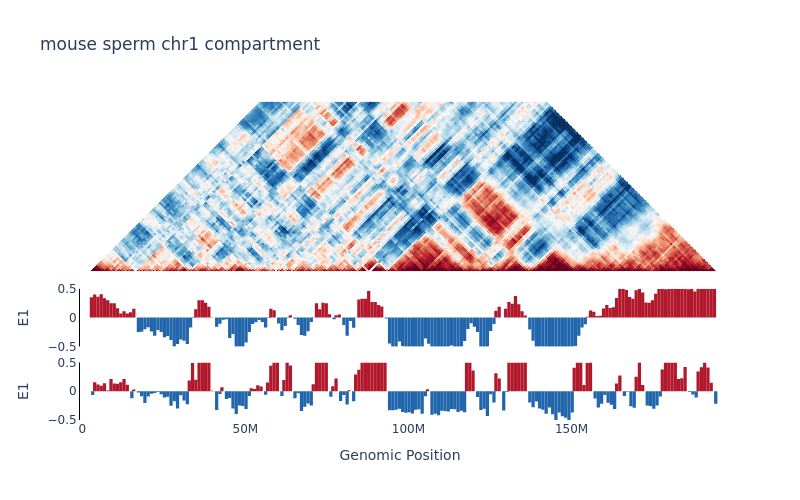

In [21]:
region = "chr1"
title = f"mouse sperm {region} compartment"
coolp0 = compartment_args["Sperm"]["coolp"]
vec_file0 = vecs["Sperm"]
vec_file1 = vecs["Sperm"]
vec_file2 = vecs["mESC_allmerge"]
coolp1 = compartment_args["Sperm"]["coolp"]
coolp2 = compartment_args["Sperm"]["coolp"]
cmap = "RdBu_r"
balance = True
strata = 3000 # 2500
outfile = f"output/mouse_sperm_{region}_compartment_triangle.png"

fig = plot_compartment_trapezoid_PNGrotate_2tracks(coolp0, vec_file1, vec_file2, region, 
    quant=0.01, minmax=None, balance=balance, strata=strata, title=title, cmap=cmap,
    vec_file0=vec_file0, coolp1=coolp1, coolp2=coolp2)
fig.update_layout(
    height = 500,
    width = 800
)
fig.show(renderer="png")
fig.write_image(outfile)

/share/home/ychi/dev/hic_basic/hic_basic/compartment.py:34: RuntimeWarning:

Mean of empty slice

/share/home/ychi/dev/hic_basic/hic_basic/compartment.py:34: RuntimeWarning:

Mean of empty slice

/share/home/ychi/dev/hic_basic/hic_basic/compartment.py:34: RuntimeWarning:

Mean of empty slice

/share/home/ychi/dev/hic_basic/hic_basic/compartment.py:34: RuntimeWarning:

Mean of empty slice



heatmap array (8000, 8000, 4)
trapezoid array (3000, 11314, 4)
output fig


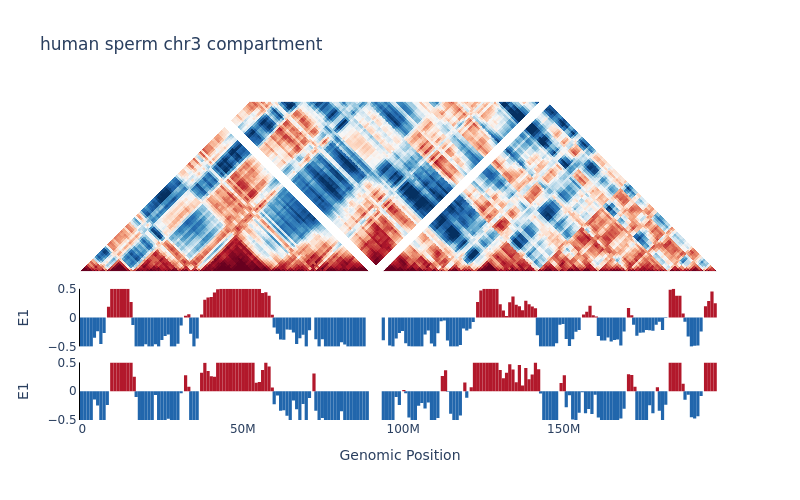

In [28]:
region = "chr3"
title = f"human sperm {region} compartment"
coolp0 = compartment_args["Sperm_hg"]["coolp"]
vec_file0 = vecs["Sperm_hg"]
vec_file1 = vecs["Sperm_hg"]
vec_file2 = vecs["Rao2014"]
coolp1 = compartment_args["Sperm_hg"]["coolp"]
coolp2 = compartment_args["Sperm_hg"]["coolp"]
cmap = "RdBu_r"
balance = True
mask_eig_na = False
strata = 3000 #2500

fig = plot_compartment_trapezoid_PNGrotate_2tracks(coolp0, vec_file1, vec_file2, region, 
    quant=0.01, minmax=None, balance=balance, strata=strata, title=title, cmap=cmap,
    vec_file0=vec_file0, coolp1=coolp1, coolp2=coolp2, mask_eig_na=mask_eig_na)
fig.update_layout(
    height = 500,
    width = 800
)
fig.show(renderer="png")
#fig.write_image("output/mouse_sperm_chr1_compartment_triangle.pdf")

In [35]:
compartment_args["Rao2014"]

{'coolp': '/share/Data/ychi/raw/Rao2014/4DN_cooler/GM12878.mcool::resolutions/1000000',
 'phasing_track': PosixPath('/shareb/ychi/repo/sperm_struct/notebooks/data2/GRCh38.gc.1m.tsv'),
 'eigen_prefix': PosixPath('/shareb/ychi/repo/sperm_struct/notebooks/data2/Rao2014')}

/share/home/ychi/dev/hic_basic/hic_basic/compartment.py:34: RuntimeWarning:

Mean of empty slice

/share/home/ychi/dev/hic_basic/hic_basic/compartment.py:34: RuntimeWarning:

Mean of empty slice

/share/home/ychi/dev/hic_basic/hic_basic/compartment.py:34: RuntimeWarning:

Mean of empty slice

/share/home/ychi/dev/hic_basic/hic_basic/compartment.py:34: RuntimeWarning:

Mean of empty slice



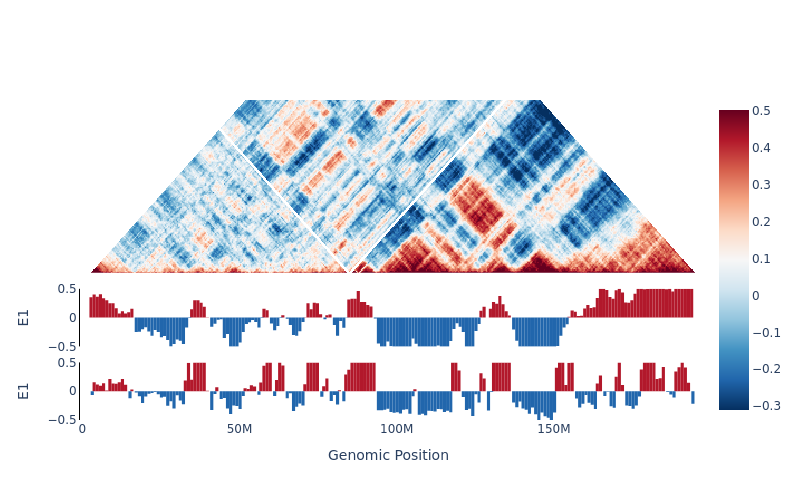

In [54]:
region = "chr1"
title = f"mouse sperm {region} compartment"
coolp0 = compartment_args["Sperm_500k"]["coolp"]
vec_file0 = vecs["Sperm_500k"]
vec_file1 = vecs["Sperm"]
vec_file2 = vecs["mESC_allmerge"]
coolp1 = compartment_args["Sperm"]["coolp"]
coolp2 = compartment_args["Sperm"]["coolp"]
cmap = "RdBu_r"
balance = True
strata = 140

fig = plot_compartment_trapezoid_2tracks(coolp0, vec_file1, vec_file2, region, 
    quant=0.01, minmax=None, balance=balance, strata=strata, title=title, cmap=cmap,
    vec_file0=vec_file0, coolp1=coolp1, coolp2=coolp2)
fig.update_layout(
    height = 500,
    width = 800
)
fig.show(renderer="png")
#fig.write_image("output/mouse_sperm_chr1_compartment_triangle.pdf")

/share/home/ychi/dev/hic_basic/hic_basic/compartment.py:34: RuntimeWarning:

Mean of empty slice

/share/home/ychi/dev/hic_basic/hic_basic/compartment.py:34: RuntimeWarning:

Mean of empty slice

/share/home/ychi/dev/hic_basic/hic_basic/compartment.py:34: RuntimeWarning:

Mean of empty slice



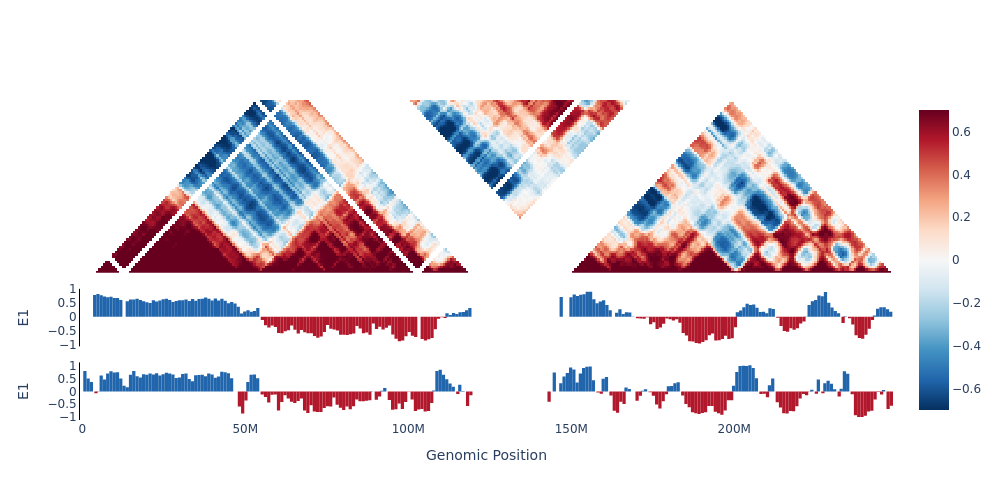

In [7]:
region = "chr1"
title = f"human sperm {region} compartment"
coolp = compartment_args["Sperm_hg"]["coolp"]
vec_file1 = vecs["Sperm_hg"]
vec_file2 = vecs["Rao2014"]
cmap = "RdBu_r"
balance = True
strata = 70

fig = plot_compartment_trapezoid_2tracks(coolp, vec_file1, vec_file2, region, balance=balance, strata=strata, title=title, cmap=cmap)
fig.update_layout(
    height = 500,
    width = 1000
)
fig.show(renderer="png")
fig.write_image("output/human_sperm_chr1_compartment_triangle.pdf")

/share/home/ychi/dev/hic_basic/hic_basic/compartment.py:34: RuntimeWarning:

Mean of empty slice

/share/home/ychi/dev/hic_basic/hic_basic/compartment.py:34: RuntimeWarning:

Mean of empty slice

/share/home/ychi/dev/hic_basic/hic_basic/compartment.py:34: RuntimeWarning:

Mean of empty slice

/share/home/ychi/dev/hic_basic/hic_basic/compartment.py:34: RuntimeWarning:

Mean of empty slice



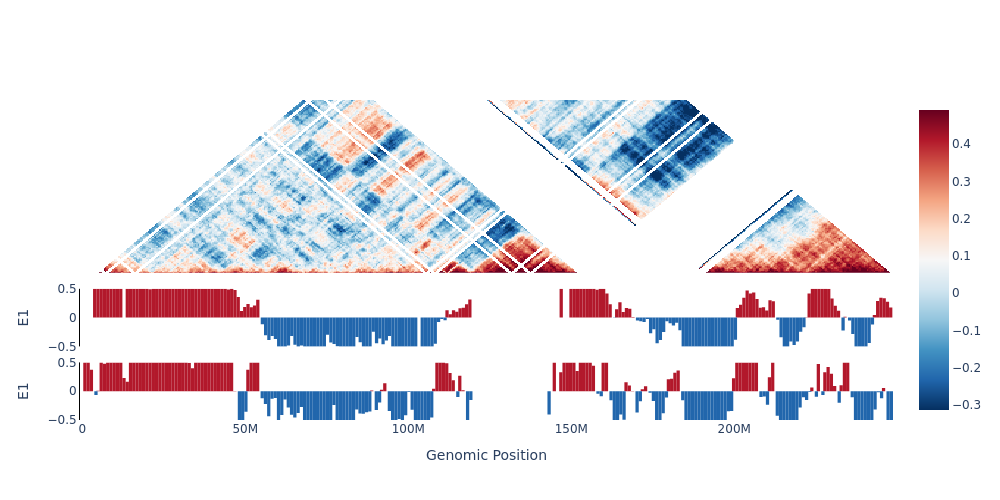

In [60]:
region = "chr1"
title = f"human sperm {region} compartment"
coolp = compartment_args["Sperm_hg_500k"]["coolp"]
vec_file0 = vecs["Sperm_hg_500k"]
vec_file1 = vecs["Sperm_hg"]
vec_file2 = vecs["Rao2014"]
coolp1 = compartment_args["Sperm_hg"]["coolp"]
coolp2 = compartment_args["Sperm_hg"]["coolp"]
cmap = "RdBu_r"
balance = True
strata = 140

fig = plot_compartment_trapezoid_2tracks(coolp0, vec_file1, vec_file2, region, 
    quant=0.01, minmax=None, balance=balance, strata=strata, title=title, cmap=cmap,
    vec_file0=vec_file0, coolp1=coolp1, coolp2=coolp2)
fig.update_layout(
    height = 500,
    width = 1000
)
fig.show(renderer="png")
#fig.write_image("output/human_sperm_chr1_compartment_triangle.pdf")